## Homework

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [102]:
import pandas as pd
import numba as nb
import numpy as np
import timeit

import matplotlib.pyplot as plt

from rectools import Columns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
qid_query = pd.read_csv("yandex_data/hidden_task/qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv("yandex_data/hidden_task/qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv("yandex_data/hidden_task/hostid_url.tsv", sep="\t", names=["hostid", "url"])


In [45]:
# делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")


def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)


def pfound(group):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    for ind, val in enumerate(top10):
        pfound += val*plook(ind, top10.values)
    return pfound


qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound) # группируем по qid и вычисляем pfound
qid_max = qid_pfound.idxmax() # берем qid с максимальным pfound

qid_query[qid_query["qid"] == qid_max]

,qid,query
14,692308,бесплатный просмотр камеди клаб


In [54]:
def mean_pfound(df: pd.DataFrame, k: int, p_break: float) -> float:
    max_rate_by_qid_hostid = df[['qid', 'rating', 'hostid']]
    max_rate_by_qid_hostid = max_rate_by_qid_hostid.groupby(['qid', 'hostid']).max()# для каждого запроса оставляем одну ссылку с максимальным рейтингом
    
    max_rate_by_qid_hostid = max_rate_by_qid_hostid.sort_values(['qid', 'rating'], ascending=False)
    
    max_rate_by_qid_hostid['order'] = max_rate_by_qid_hostid.groupby('qid').cumcount() + 1 #нумеруем документы по убыванию рейтинга
    topk_recs_for_qid = max_rate_by_qid_hostid[max_rate_by_qid_hostid['order'] <= k] #выбираем топ к рекомендаций
    topk_recs_for_qid = topk_recs_for_qid.reset_index()
    
    topk_recs_for_qid['pred_pReil'] = topk_recs_for_qid['rating'].shift(1) #добавляем столбец с рел-1
    
    topk_recs_for_qid['pLookMulti'] = (1 - topk_recs_for_qid['pred_pReil']) * (1 - p_break) # считаем второй множитель
    topk_recs_for_qid.loc[(topk_recs_for_qid['order'] == 1), 'pLookMulti'] = 1 # устанавливаем первый  равный 1
    topk_recs_for_qid['pLook'] = topk_recs_for_qid.groupby('qid')['pLookMulti'].cumprod() # счтаем рекурсивно plook
    topk_recs_for_qid['pFound'] = topk_recs_for_qid['pLook'] * topk_recs_for_qid['rating'] # считаем формулу
    topk_recs_for_qid = topk_recs_for_qid.reset_index().drop(['pLook','pLookMulti','pred_pReil','order'], axis=1)
    return topk_recs_for_qid.groupby(['qid']).sum()['pFound'].mean()
    

In [55]:
%%timeit
mean_pfound(qid_url_rating_hostid, 10, 0.15)

6.74 ms ± 91.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<h1>MRR</h1>

In [56]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

<h2>Naive MRR</h2>

In [76]:
def mrr_naive(target, users, recs):
    mrr = []
    r = 0
    for i, user in enumerate(users):
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                r = 1/(j+1)
                break
            else:
                r = 0
        mrr.append(r)
    return sum(mrr)/len(users)

<h2>Pandas MRR</h2>

In [80]:
def mrr_pandas(df, users, recs):
    k = recs.shape[1]
    df_recs = pd.DataFrame({'user_id': np.repeat(users, k), 'item_id': recs.ravel()})
    df_recs['rank'] = df_recs.groupby('user_id').cumcount() + 1
    df['target'] = 1
    df_recs = df_recs.merge(df, how='left', left_on=['user_id', 'item_id'], right_on=['user_id', 'item_id'])
    df.drop(['target'], axis=1, inplace=True)
    df_recs['reciprocal_rank'] = 0
    df_recs.loc[~df_recs['target'].isna(), 'reciprocal_rank'] = 1/(df_recs.loc[~df_recs['target'].isna(), 'rank'])
    mrr = df_recs.groupby('user_id')['reciprocal_rank'].max().sum()/len(users)
    return mrr

<h2>Numba MRR</h2>

In [84]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target,users, recs):
    result_mrr = np.zeros(len(users))
    for i in nb.prange(len(users)):
        mrr = 0.0
        user = users[i]
        user_target = target[target[:, 0] == user][:, 1]
        for j, rec in enumerate(recs[i]):
            if rec in user_target:
                mrr = 1 / (j + 1)
                break
        result_mrr[i] = mrr
    return result_mrr.mean()


<h2>Посчитаем время выполнения каждого варианта MRR</h2>

In [69]:
interactions = pd.read_csv('itmo_recsys_2022-main/Lecture 2. Validation and metrics/data_original/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [77]:
k = 10
df, users, recs = generate_subsample(500, k)
target = df.values

In [90]:
%%time
mrr_naive(target, users, recs)


CPU times: user 42.7 ms, sys: 137 µs, total: 42.8 ms
Wall time: 41.7 ms


0.06255238095238096

In [91]:
%%time
mrr_pandas(df, users, recs)


CPU times: user 12.9 ms, sys: 50 µs, total: 13 ms
Wall time: 11.9 ms


0.06255238095238096

In [92]:
%%time
mrr_numba(target, users, recs)

CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 1.1 ms


0.06255238095238096

In [100]:

users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]

naive_time = []
numba_time = []
pandas_time = []

for k in top_k:
    time_k_naive = []
    time_k_pandas = []
    time_k_numba = []
    
    for j in range(len(users_count)):
        df, users, recs = generate_subsample(users_count[j], k)
        target = df.values
        time = timeit.timeit('mrr_naive(target, users, recs)', "from __main__ import mrr_naive, target, users, recs", number = 1)
        time_k_naive.append(time)
        print("naive time: ", time, " users count: ", users_count[j], " k: ", k)
        time = timeit.timeit('mrr_pandas(df, users, recs)', "from __main__ import mrr_pandas, df, users, recs", number = 1)
        time_k_pandas.append(time)
        print("pandas time:  ", time, " users count: ", users_count[j], " k: ", k)
        time = timeit.timeit('mrr_numba(target, users, recs)', "from __main__ import mrr_numba, target, users, recs", number = 1)
        time_k_numba.append(time)
        print("numba time:  ", time, " users count: ", users_count[j], " k: ", k)

    naive_time.append(time_k_naive)    
    numba_time.append(time_k_numba)    
    pandas_time.append(time_k_pandas)

naive time:  0.003408632008358836  users count:  100  k:  10
pandas time:   0.004810140002518892  users count:  100  k:  10
numba time:   0.00018045003525912762  users count:  100  k:  10
naive time:  0.05074156983755529  users count:  1000  k:  10
pandas time:   0.006852603051811457  users count:  1000  k:  10
numba time:   0.00298741995356977  users count:  1000  k:  10
naive time:  1.7219676850363612  users count:  10000  k:  10
pandas time:   0.03370160306803882  users count:  10000  k:  10
numba time:   0.1560091010760516  users count:  10000  k:  10
naive time:  138.58993010316044  users count:  100000  k:  10
pandas time:   0.3688172248657793  users count:  100000  k:  10
numba time:   11.525256525026634  users count:  100000  k:  10
naive time:  0.009963625110685825  users count:  100  k:  50
pandas time:   0.005042257020249963  users count:  100  k:  50
numba time:   0.00015869899652898312  users count:  100  k:  50
naive time:  0.11268860404379666  users count:  1000  k:  50


<h2>Скорость работы в зависимости от количества пользователей при разном К</h2>

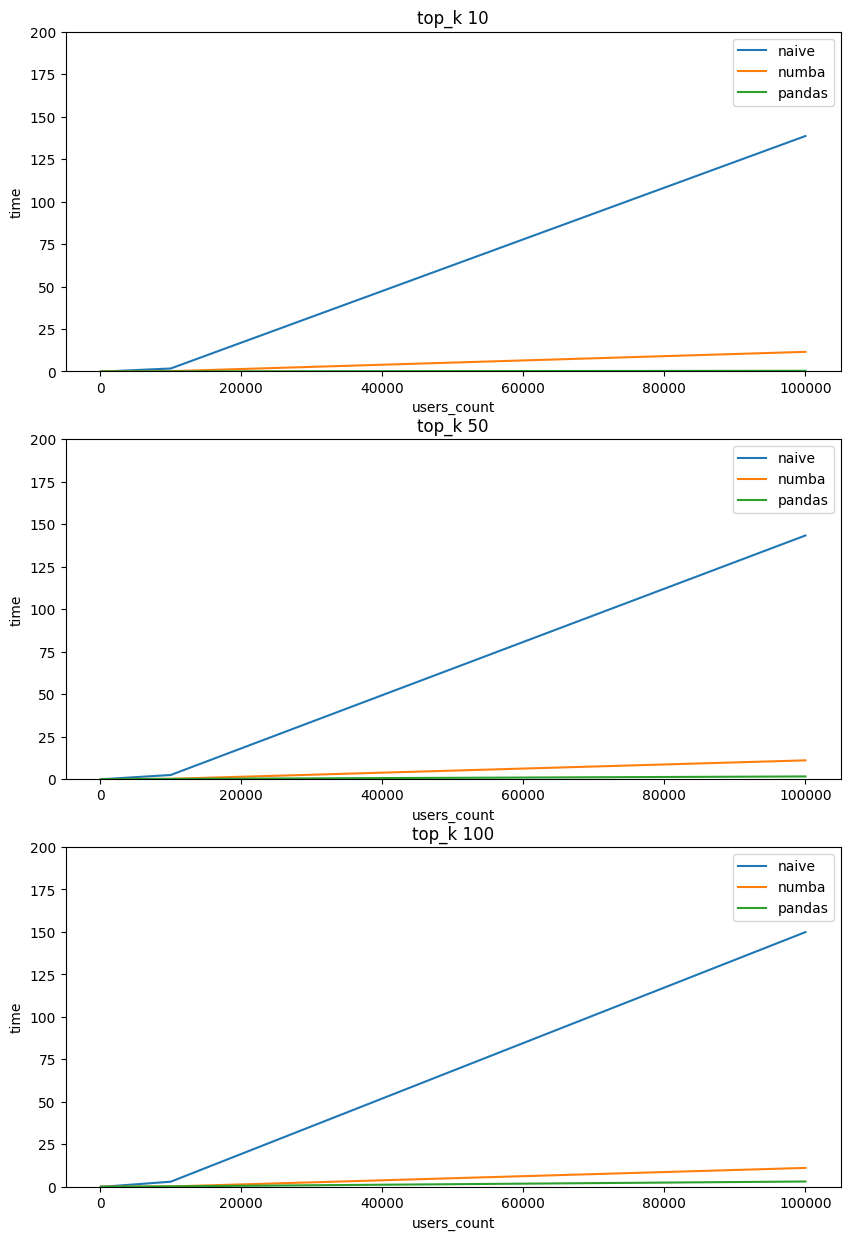

In [108]:
fx, ax = plt.subplots(3, figsize=(10, 15))
for i in range(3):
    ax[i].plot(users_count, naive_time[i], label='naive')
    ax[i].plot(users_count, numba_time[i], label='numba')
    ax[i].plot(users_count, pandas_time[i], label='pandas')
    ax[i].set_title(f'top_k {top_k[i]}')
    ax[i].set_ylabel('time')
    ax[i].set_xlabel('users_count')
    ax[i].set_ylim(0, 200)
    ax[i].legend()
plt.show()
